In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import sys
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from wisard.encoders import ThermometerEncoder, encode_dataset
from wisard.wisard import WiSARD, model_from_coded_mental_image
from wisard.utils import untie, get_random_permutation, permute_dataset_bits
from wisard.optimize import find_best_bleach_bayesian, find_best_bleach_bin_search

from wisard.data import IrisDataset
from keras.datasets import mnist, fashion_mnist


%matplotlib inline

2022-08-05 01:28:36.122884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 01:28:36.122935: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def sample_digit(target: int, X, y):
    return next((digit for (digit, label) in zip(X, y)
                 if int(label) == int(target))).reshape((28, 28))


def display_mnist_digits(X,
                         y,
                         figsize=(16, 8),
                         vmin: float = None,
                         vmax: float = None,
                         cmap: str = "gray"):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for i in range(2):
        for j in range(5):
            im = axs[i, j].imshow(
                sample_digit(target=5 * i + j, X=X, y=y),
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
            )
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
            if vmin is None or vmax is None:
                fig.colorbar(im, ax=axs[i, j], shrink=0.6)
    if vmin is not None and vmax is not None:
        fig.colorbar(im, ax=axs[:, 4], location="right", shrink=0.6)
    plt.show()


def do_train_and_evaluate(x_train,
                          y_train,
                          x_test,
                          y_test,
                          tuple_size: int,
                          input_indexes: List[int] = None,
                          shuffle_indexes: bool = True,
                          bleach: Union[int, str] = "auto",
                          **kwargs):
    num_classes = len(np.unique(y_train))

    print(" ----- Training model ----- ")            

    if input_indexes is None:
        input_indexes = np.arange(x_train[0].size)
    if shuffle_indexes:
        np.random.shuffle(input_indexes)
    print(f"Using input_indexes: {input_indexes}")

    model = WiSARD(num_inputs=x_train[0].size,
                   num_classes=num_classes,
                   unit_inputs=tuple_size,
                   unit_entries=1,
                   unit_hashes=1,
                   input_idxs=input_indexes,
                   shared_rand_vals=False,
                   randomize=False)

    model.fit(x_train, y_train)
    max_bleach = model.max_bleach()
    print(f"Max bleach is: {max_bleach}\n")

    print(" ----- Evaluating model ----- ")

    if isinstance(bleach, int):
        y_pred = model.predict(x_test, y_test, bleach=bleach, use_tqdm=True)
        y_pred, ties = untie(y_pred, use_tqdm=False)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}")
    elif bleach == "auto":
        bleach = find_best_bleach_bin_search(model,
                                           X=x_test,
                                           y=y_test,
                                           min_bleach=1,
                                           max_bleach=max_bleach,
                                           **kwargs)
    else:
        raise ValueError(f"Invalid value for bleach: '{bleach}'")

    return model, bleach

# MNIST

Encoder:
- Type: Thermometer
- Resolution: 16
- Min, max: 0, 255

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

array([3588,  174, 1690, ..., 1506, 4094,  409])

In [5]:
x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 83295.68it/s]


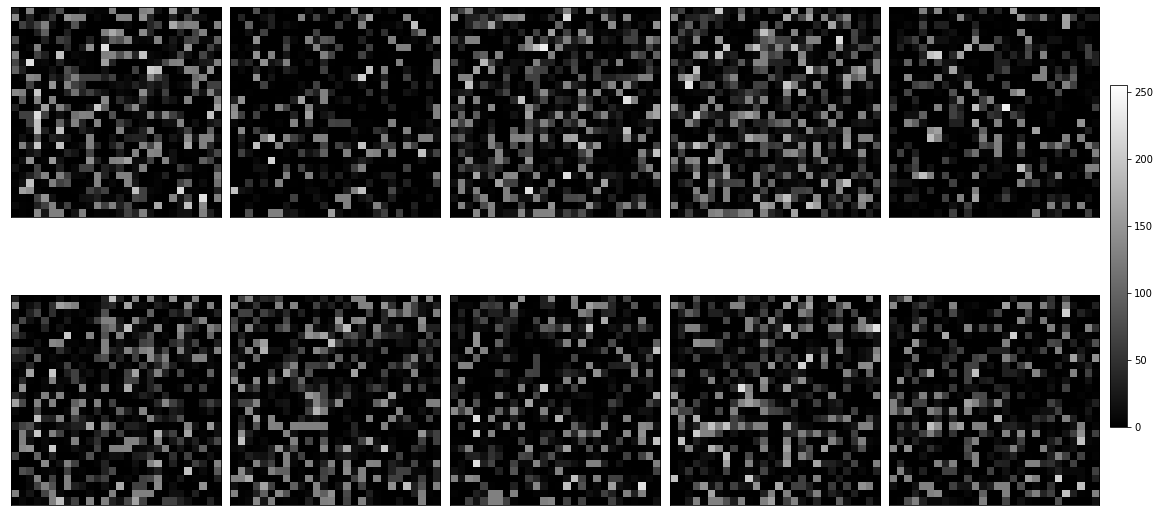

In [6]:
display_mnist_digits(x_train, y_train, vmin=0, vmax=255)

In [7]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=16)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████| 10000/10000 [00:00<00:00, 12323.68it/s]


In [8]:
input_size = x_train[0].size
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()

model, bleach = do_train_and_evaluate(x_train,
                                      y_train,
                                      x_test,
                                      y_test,
                                      input_indexes=input_idxs,
                                      tuple_size=16,
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [    0   784  1568 ... 10975 11759 12543]


Training model: 100%|██████████████████████████████████████████| 60000/60000 [01:01<00:00, 972.64it/s]


Max bleach is: 6738

 ----- Evaluating model ----- 
Testing with bleach=1685
[b=1685] Accuracy=0.720, ties=77
Testing with bleach=3369
[b=3369] Accuracy=0.213, ties=43
Testing with bleach=5053
[b=5053] Accuracy=0.114, ties=0
Testing with bleach=843
[b=843] Accuracy=0.819, ties=97
Testing with bleach=1685
[b=1685] Accuracy=0.720
Testing with bleach=2527
[b=2527] Accuracy=0.477, ties=84
Testing with bleach=422
[b=422] Accuracy=0.814, ties=147
Testing with bleach=843
[b=843] Accuracy=0.819
Testing with bleach=1264
[b=1264] Accuracy=0.797, ties=89
Testing with bleach=633
[b=633] Accuracy=0.818, ties=98
Testing with bleach=843
[b=843] Accuracy=0.819
Testing with bleach=1053
[b=1053] Accuracy=0.817, ties=99
Testing with bleach=738
[b=738] Accuracy=0.823, ties=94
Testing with bleach=843
[b=843] Accuracy=0.819
Testing with bleach=948
[b=948] Accuracy=0.815, ties=81
Testing with bleach=686
[b=686] Accuracy=0.819, ties=89
Testing with bleach=738
[b=738] Accuracy=0.823
Testing with bleach=790
[b=

Encoder:
- Type: Thermometer
- Resolution: 8
- Min, max: 0, 255

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

array([2466, 6106,  156, ...,  289,  619,  970])

In [10]:
x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 79750.38it/s]


In [11]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=8)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████| 10000/10000 [00:00<00:00, 19576.75it/s]


In [12]:
input_size = x_train[0].size
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()

model, bleach = do_train_and_evaluate(x_train,
                                      y_train,
                                      x_test,
                                      y_test,
                                      input_indexes=input_idxs,
                                      tuple_size=8,
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [   0  784 1568 ... 4703 5487 6271]


Training model: 100%|█████████████████████████████████████████| 60000/60000 [00:30<00:00, 1938.91it/s]


Max bleach is: 6663

 ----- Evaluating model ----- 
Testing with bleach=1666
[b=1666] Accuracy=0.512, ties=179
Testing with bleach=3331
[b=3331] Accuracy=0.131, ties=124
Testing with bleach=4996
[b=4996] Accuracy=0.116, ties=169
Testing with bleach=834
[b=834] Accuracy=0.749, ties=104
Testing with bleach=1666
[b=1666] Accuracy=0.512
Testing with bleach=2498
[b=2498] Accuracy=0.243, ties=175
Testing with bleach=418
[b=418] Accuracy=0.843, ties=92
Testing with bleach=834
[b=834] Accuracy=0.749
Testing with bleach=1250
[b=1250] Accuracy=0.639, ties=172
Testing with bleach=210
[b=210] Accuracy=0.850, ties=130
Testing with bleach=418
[b=418] Accuracy=0.843
Testing with bleach=626
[b=626] Accuracy=0.803, ties=99
Testing with bleach=106
[b=106] Accuracy=0.840, ties=244
Testing with bleach=210
[b=210] Accuracy=0.850
Testing with bleach=314
[b=314] Accuracy=0.850, ties=110
Testing with bleach=262
[b=262] Accuracy=0.853, ties=106
Testing with bleach=314
[b=314] Accuracy=0.850
Testing with bleach

Encoder:
- Type: Thermometer
- Resolution: 24
- Min, max: 0, 255

In [25]:
resolution = 24
tuple_size = 24

(x_train, y_train), (x_test, y_test) = mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=resolution)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

input_size = x_train[0].size
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()

model, bleach = do_train_and_evaluate(x_train,
                                      y_train,
                                      x_test,
                                      y_test,
                                      input_indexes=input_idxs,
                                      tuple_size=tuple_size,
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

Encoding dataset: 100%|███████████████████████████████████████| 10000/10000 [00:01<00:00, 8379.04it/s]


 ----- Training model ----- 
Using input_indexes: [    0   784  1568 ... 17247 18031 18815]


Training model: 100%|██████████████████████████████████████████| 60000/60000 [01:08<00:00, 875.90it/s]


Max bleach is: 6741

 ----- Evaluating model ----- 
Testing with bleach=1685
[b=1685] Accuracy=0.688, ties=85
Testing with bleach=3370
[b=3370] Accuracy=0.163, ties=25
Testing with bleach=5055
[b=5055] Accuracy=0.114, ties=0
Testing with bleach=843
[b=843] Accuracy=0.820, ties=79
Testing with bleach=1685
[b=1685] Accuracy=0.688
Testing with bleach=2527
[b=2527] Accuracy=0.419, ties=96
Testing with bleach=422
[b=422] Accuracy=0.797, ties=138
Testing with bleach=843
[b=843] Accuracy=0.820
Testing with bleach=1264
[b=1264] Accuracy=0.785, ties=73
Testing with bleach=633
[b=633] Accuracy=0.805, ties=95
Testing with bleach=843
[b=843] Accuracy=0.820
Testing with bleach=1053
[b=1053] Accuracy=0.818, ties=69
Testing with bleach=738
[b=738] Accuracy=0.814, ties=84
Testing with bleach=843
[b=843] Accuracy=0.820
Testing with bleach=948
[b=948] Accuracy=0.823, ties=74
Testing with bleach=896
[b=896] Accuracy=0.823, ties=67
Testing with bleach=948
[b=948] Accuracy=0.823
Testing with bleach=1000
[b

# Fashion MIST

Encoder:
- Type: Thermometer
- Resolution: 16
- Min, max: 0, 255

In [13]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

array([5971, 3666, 5398, ..., 3739, 1383, 3964])

In [14]:
x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 83494.16it/s]


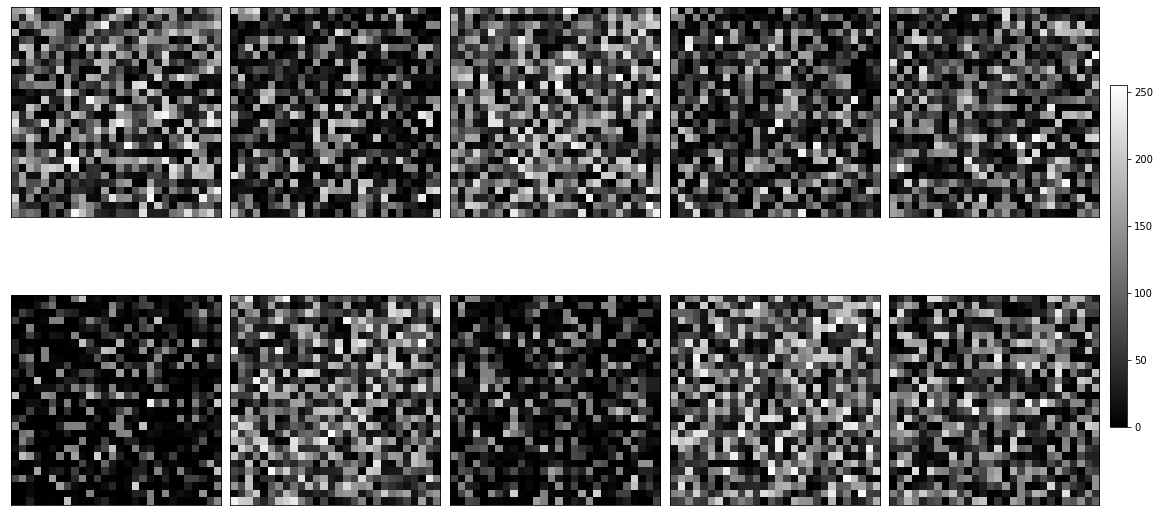

In [15]:
display_mnist_digits(x_train, y_train, vmin=0, vmax=255)

In [16]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=16)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████| 10000/10000 [00:00<00:00, 13073.52it/s]


In [17]:
input_size = x_train[0].size
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()

model, bleach = do_train_and_evaluate(x_train,
                                      y_train,
                                      x_test,
                                      y_test,
                                      input_indexes=input_idxs,
                                      tuple_size=16,
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [    0   784  1568 ... 10975 11759 12543]


Training model: 100%|██████████████████████████████████████████| 60000/60000 [01:50<00:00, 542.07it/s]


Max bleach is: 6000

 ----- Evaluating model ----- 
Testing with bleach=1500
[b=1500] Accuracy=0.630, ties=95
Testing with bleach=3000
[b=3000] Accuracy=0.444, ties=177
Testing with bleach=4500
[b=4500] Accuracy=0.266, ties=139
Testing with bleach=750
[b=750] Accuracy=0.719, ties=98
Testing with bleach=1500
[b=1500] Accuracy=0.630
Testing with bleach=2250
[b=2250] Accuracy=0.468, ties=124
Testing with bleach=375
[b=375] Accuracy=0.658, ties=136
Testing with bleach=750
[b=750] Accuracy=0.719
Testing with bleach=1125
[b=1125] Accuracy=0.685, ties=80
Testing with bleach=563
[b=563] Accuracy=0.695, ties=102
Testing with bleach=750
[b=750] Accuracy=0.719
Testing with bleach=937
[b=937] Accuracy=0.707, ties=69
Testing with bleach=657
[b=657] Accuracy=0.714, ties=110
Testing with bleach=750
[b=750] Accuracy=0.719
Testing with bleach=843
[b=843] Accuracy=0.714, ties=92
Testing with bleach=704
[b=704] Accuracy=0.716, ties=88
Testing with bleach=750
[b=750] Accuracy=0.719
Testing with bleach=796

Encoder:
- Type: Thermometer
- Resolution: 8
- Min, max: 0, 255

In [18]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

array([5890,   66, 5314, ...,  457, 1975, 2001])

In [19]:
x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 83937.95it/s]


In [20]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=8)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████| 10000/10000 [00:00<00:00, 20247.83it/s]


In [21]:
input_size = x_train[0].size
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()

model, bleach = do_train_and_evaluate(x_train,
                                      y_train,
                                      x_test,
                                      y_test,
                                      input_indexes=input_idxs,
                                      tuple_size=8,
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [   0  784 1568 ... 4703 5487 6271]


Training model: 100%|█████████████████████████████████████████| 60000/60000 [00:55<00:00, 1078.07it/s]


Max bleach is: 5909

 ----- Evaluating model ----- 
Testing with bleach=1477
[b=1477] Accuracy=0.581, ties=128
Testing with bleach=2954
[b=2954] Accuracy=0.234, ties=70
Testing with bleach=4431
[b=4431] Accuracy=0.251, ties=235
Testing with bleach=739
[b=739] Accuracy=0.667, ties=124
Testing with bleach=1477
[b=1477] Accuracy=0.581
Testing with bleach=2215
[b=2215] Accuracy=0.319, ties=108
Testing with bleach=370
[b=370] Accuracy=0.652, ties=229
Testing with bleach=739
[b=739] Accuracy=0.667
Testing with bleach=1108
[b=1108] Accuracy=0.682, ties=128
Testing with bleach=924
[b=924] Accuracy=0.697, ties=123
Testing with bleach=1108
[b=1108] Accuracy=0.682
Testing with bleach=1292
[b=1292] Accuracy=0.646, ties=123
Testing with bleach=832
[b=832] Accuracy=0.691, ties=133
Testing with bleach=924
[b=924] Accuracy=0.697
Testing with bleach=1016
[b=1016] Accuracy=0.698, ties=136
Testing with bleach=970
[b=970] Accuracy=0.694, ties=122
Testing with bleach=1016
[b=1016] Accuracy=0.698
Testing wi